In [1]:
push!(LOAD_PATH,"/Users/simone/Documents/uni/postdoc/projects/FeedbackParticleFilters.jl/src/")
using FeedbackParticleFilters

using StatsBase
using LinearAlgebra
using Distributed
using PyPlot

# Single gain computation

In [2]:
# numerical integral over R by transform
function finv(y::Float64)
    return tan(pi*y/2)#log((1+y)/(1-y))
end

function finvprime(y::Float64)
    return pi/(1+cos(pi*y))#2/(1-y^2)
end

function NumIntR(fun::Function, n::Int64)
    x = zeros(Float64, n+1)
    int = zeros(Float64, n+1)
    dy = 2. / (n+1)
    y = -1. -dy/2
    for i = 2:(n+1)
        y = y + dy
        x[i] = finv(y)
        int[i] = int[i-1] + fun(x[i]) * dy * finvprime(y)
    end
    x[2:n+1], int[2:n+1]
end;

In [3]:
# Settings
function p(x::Float64)
    ( exp(-(x-1)^2/(2*0.16))+exp(-(x+1)^2/(2*0.16)) ) / sqrt(8*pi*0.16)
end;

function h(x::Float64)
    x
end;

In [4]:
hbar = NumIntR(x -> h(x)*p(x),1000)[2][end]

-6.876696392728779e-16

In [5]:
xx,int = NumIntR(x -> -(h(x)-hbar)*p(x),1000);
K_exact = int ./ p.(xx);

In [6]:
N=1000
positions=vcat(0.4.*randn(div(N,2)).-1,0.4.*randn(div(N,2)).+1)
testens=FPFEnsemble(positions,N,ScalarObservationData(positions,mean(positions)),GainDataSemigroup1d(zeros(Float64,N),ones(Float64,N)));
eq=ScalarPoissonEquation(h, testens);

In [7]:
@time Solve!(eq, SemigroupMethod1d(0.1,1E-4));

  1.089562 seconds (2.45 M allocations: 139.186 MiB, 7.07% gc time)


In [8]:
@time Update!(eq, testens);

  0.043903 seconds (140.42 k allocations: 7.156 MiB)


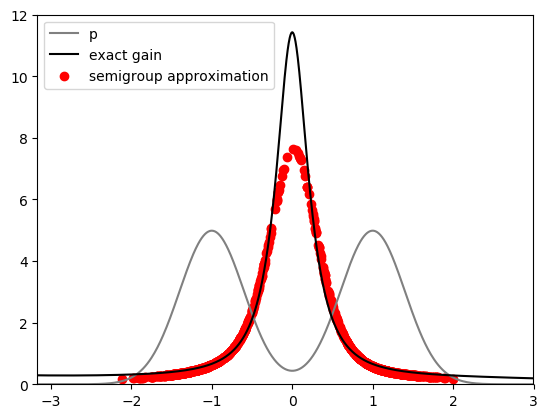

In [9]:
xlim((1.5*minimum(testens.positions),1.5*maximum(testens.positions)))
ylim((0,12))
plot(xx, 10*p.(xx), color="gray");
plot(xx, K_exact, color="black");
scatter(eq.positions, eq.gain, color="red");
#scatter(testens.positions, testens.potential)
#hist(testens.positions,50)
legend(("p","exact gain","semigroup approximation"));

# Loop

In [14]:
# simulate sequential gain estimation and update
N=1000
positions=vcat(0.4.*randn(div(N,2)).-1,0.4.*randn(div(N,2)).+1)
testens=FPFEnsemble(positions,N,ScalarObservationData(positions,mean(positions)),GainDataSemigroup1d(zeros(Float64,N),ones(Float64,N)));
eq=ScalarPoissonEquation(x->h(x), testens);
n_time = 100 # number of time steps
positions = zeros(n_time,N)
potentials = zeros(n_time,N)
gains = zeros(n_time,N)
@time for i = 1:n_time
    Update!(eq, testens)
    Solve!(eq, SemigroupMethod1d(0.1,0.01))
    positions[i,:] = testens.positions
    #testens.gain_data.potential = eq.potential
    #testens.gain_data.gain = eq.gain
    potentials[i,:] = eq.potential
    gains[i,:] = eq.gain
    ApplyGain!(testens, eq, 1E-2)
end

  2.865437 seconds (43.78 k allocations: 1.515 GiB, 3.52% gc time)


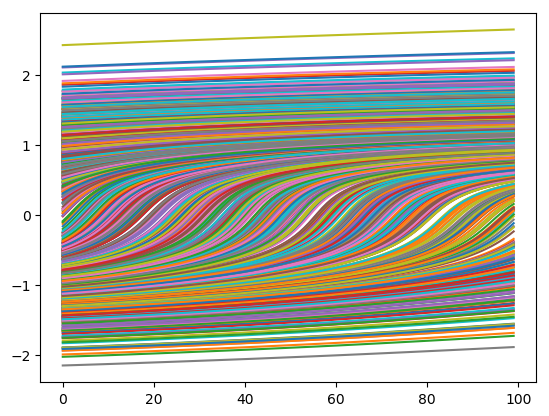

In [15]:
plot(positions[:,:]);

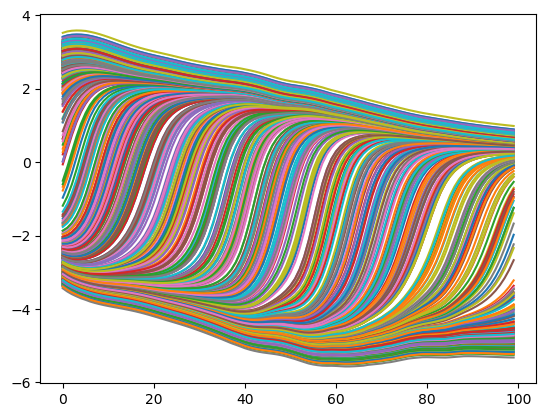

In [16]:
plot(potentials[:,:]);

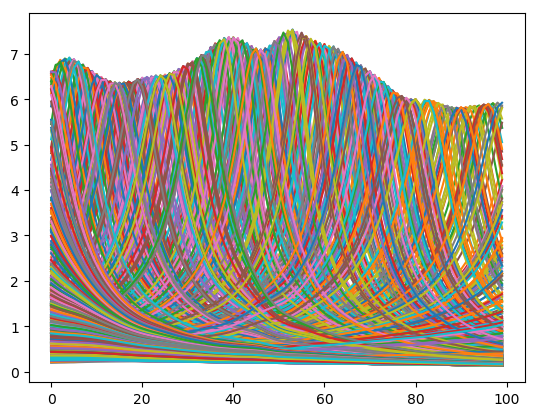

In [17]:
plot(gains[:,:]);